# FLIR One Pro sensor calibration

It appears as if the raw RGB and FIR images do not line up exactly.
This notebook briefly explores ways to align the images.

(Note that in the code `VIS`: visible, `THR`: thermal/FIR)

In [1]:
import os
import json
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [15, 11]
import numpy as np
import cv2
from pprint import pprint

## Utilities

In [18]:
def load_images(path, name):
    """
        Loads original, thermal and visible image from dataset
    """
    original = cv2.imread(os.path.join(path, name)) / 255
    thermal = cv2.imread(os.path.join(path, "extracted/thermal", name)) / 255
    visible = cv2.imread(os.path.join(path, "extracted/visible", name)) / 255
    return original, thermal, visible

def load_prepare(path, name):
    """
        Loads images, scales VIS and FIR to shape and collapses to 1 channel
    """
    orig, thr, vis = load_images(path, name)
    
    # Compress into single channel
    thr = np.mean(thr, 2)
    vis = np.mean(vis, 2)

    # Align shapes
    vis = cv2.resize(vis, (thr.shape[1], thr.shape[0]))
    return orig, thr, vis

def superimpose(a, b):
    """
        Superimposes 2 images
    """
    return np.mean(np.dstack([a, b]), axis=2)

def show(img, ax, title, neg=True):
    """
        Displays an image.
        Uses negative by default for better visibility.
    """
    ax.imshow(1-img if neg else img)
#     ax.set_title(title)
    ax.axis("off")

## Load metadata

This file contains experimental results, filenames and annotations.

In [3]:
root_path = "../../data/calibration"
with open(os.path.join(root_path, "metadata.json")) as f:
    metadata = json.load(f)
    
scaling_factor = metadata["shape"]["vis"][0] / metadata["shape"]["thr"][0]
pprint(metadata)

{'candle_distances': {'left_middle': 415, 'middle_right': 380},
 'photos': {'flir_20191112T174218.jpg': {'adjusted': False,
                                         'distance': 1150,
                                         'points': {'thr': [[122, 202],
                                                            [322, 187],
                                                            [513, 187]],
                                                    'vis': [[362, 441],
                                                            [742, 424],
                                                            [1094, 422]]}},
            'flir_20191112T174252.jpg': {'adjusted': False,
                                         'distance': 1950,
                                         'points': {'thr': [[225, 218],
                                                            [346, 206],
                                                            [458, 207]],
                                            

## Display test images

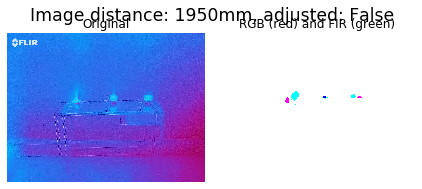

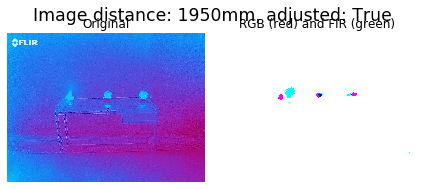

In [4]:
def display_images(path, name, metadata):
    orig, thr, vis = load_prepare(path, name)

    # Threshold
    vis = np.where(vis > 0.91, 1, 0)
    thr = np.where(thr > 0.15, 1, 0)

    # Overlay as red and green channel and plot
    ovr = np.dstack([vis, thr, np.zeros(thr.shape)])
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    show(orig, ax1, "Original", neg=False)
    show(ovr, ax2, "RGB (red) and FIR (green)")
    
    distance = metadata["photos"][name]["distance"]
    adjusted = metadata["photos"][name]["adjusted"]
    fig.suptitle(f"Image distance: {distance}mm, adjusted: {adjusted}", y=0.85, size="xx-large")
    plt.tight_layout()


display_images(root_path, list(metadata["photos"].keys())[1], metadata)
display_images(root_path, list(metadata["photos"].keys())[6], metadata)

Above visualisations show that, even if the image appears aligned in the FLIR One app, the raw FIR and RGB images are not necessarily aligned. The slider in the app seems to only affect the final output image, but not the underlying FIR and RGB images. Therefore, one of the components must be translated after extraction to align with the other one.

In [5]:
# Another image
# display_images(list(metadata["photos"].keys())[0], metadata)

## Manually align images by zooming

In [6]:
def manual_align(path, name, fac=0.09):
    orig, thr, vis = load_prepare(path, name)
    x, y = vis.shape

    # Rescale images
    vis_r = vis[int(x*fac):int(x*(1-fac)), int(y*fac):int(y*(1-fac))]
    vis_r = cv2.resize(vis_r, (thr.shape[1], thr.shape[0]))

    # Threshold
    vis_t = np.where(vis_r > 0.91, 1, 0)
    thr_t = np.where(thr > 0.15, 1, 0)

    # Overlay/superimpose
    ov = np.dstack([vis_t, thr_t, np.zeros(thr.shape)])
    sup = superimpose(vis, thr*3)
    sup_r = superimpose(vis_r, thr*3)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    show(orig, ax1, "Original")
    show(ov, ax2, "Rescaled RGB (red) and FIR (green)")
    show(sup, ax3, "Original superimposed")
    show(sup_r, ax4, "Rescaled superimposed")

    fig.suptitle(f"Before and after rescaling", size="xx-large")
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)

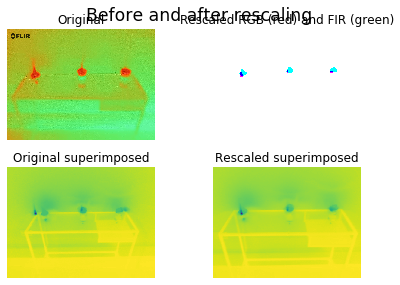

In [7]:
manual_align(root_path, list(metadata["photos"].keys())[0], fac=0.09)

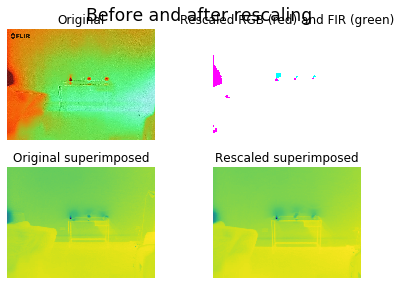

In [8]:
manual_align(root_path, list(metadata["photos"].keys())[3], fac=0.09)

## Learn linear transformation

Use linear regression to estimate the parameters of an affine transformation.

In [9]:
from sklearn.linear_model import LinearRegression

/Users/lindronics/opt/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

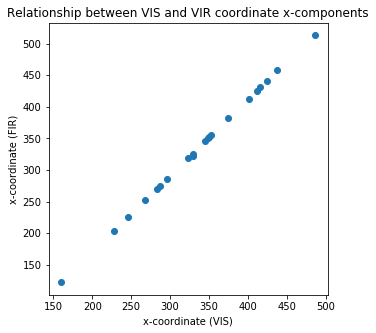

In [10]:
# Load reference points

X, y = [], []
for name, image in metadata["photos"].items():
    try:
        X.append(metadata["photos"][name]["points"]["vis"])
        y.append(metadata["photos"][name]["points"]["thr"])
    except:
        pass
    
X = np.vstack(X) // scaling_factor
y = np.vstack(y)

# Plot thermal x-value over visible x-value
# there appears to be a linear relationship
fig, ax = plt.subplots(1, figsize=(5,5))
ax.scatter(X[:, 0], y[:, 0])
ax.set_xlabel("x-coordinate (VIS)")
ax.set_ylabel("x-coordinate (FIR)")
ax.set_title("Relationship between VIS and VIR coordinate x-components")
fig.show()

model = LinearRegression()
model.fit(X, y)

## Visualise transformation using points and vectors

In [11]:
def show_transform(path, name, metadata, coef, intercept, scaling_factor):
    """
        Displays transformation vectors as an overlay
        over the superimposed FIR and RGB image
    """
    orig, thr, vis = load_prepare(path, name)
    
    # Display superimposed image
    sup = superimpose(vis, thr*3)
    
    fig, ax = plt.subplots(1)
    show(sup, ax, "Transformation of selected points", neg=False)

    # Test points
    X_test = np.array([[100, 100], [550, 100], [100, 400], [550, 400]])
    X_test = np.vstack([X_test, np.array(metadata["photos"][name]["points"]["vis"]) / scaling_factor])

    # Arrows
    y_pred = model.predict(X_test)
    for i in range(X_test.shape[0]):
        ax.annotate("", xy=X_test[i] @ coef.T + intercept, xytext=X_test[i], arrowprops=dict(arrowstyle="->", color="white", linewidth=3))

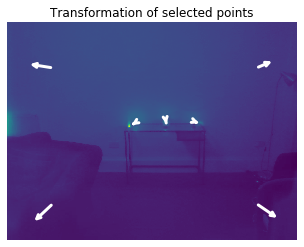

In [12]:
show_transform(root_path, "flir_20191112T174307.jpg", metadata, model.coef_, model.intercept_, scaling_factor)

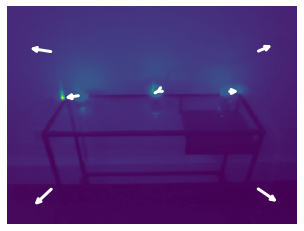

In [19]:
show_transform(root_path, "flir_20191112T174218.jpg", metadata, model.coef_, model.intercept_, scaling_factor)

## Align and superimpose using affine transformation

In [16]:
from scipy.ndimage import affine_transform

def align(path, name, coef, intercept, portrait=False):
    _, thr, vis = load_prepare(path, name)
    
    sup_before = superimpose(vis, thr*3)
    
    # If portrait mode, rotate images so that the transformation works properly
    if portrait:
        thr = np.rot90(thr, 1)
        vis = np.rot90(vis, 1)
        
    transformation = np.hstack([coef, intercept[:, None]])
    vis = cv2.warpAffine(vis, transformation, (thr.shape[1], thr.shape[0]))

    sup_after = superimpose(vis, thr*3)
    
    if portrait:
        sup_after = np.rot90(sup_after, 3)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    show(sup_before, ax1, "Before transformation")
    show(sup_after, ax2, "After transformation")
    
#     fig.suptitle(f"Aligning FIR and VIS by affine transformation", y=.82, size="xx-large")
    plt.tight_layout()

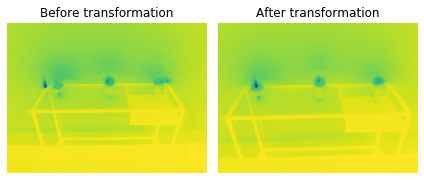

In [17]:
align(root_path, "flir_20191112T174218.jpg", model.coef_, model.intercept_)

## Validate on different image

Finally, verify that the transformation generalises to all images captured with the sensor.

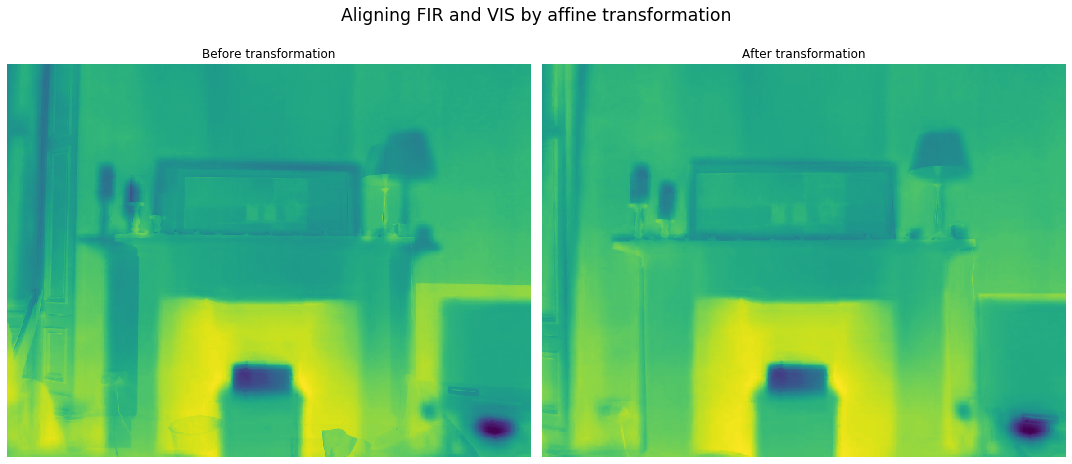

In [84]:
new_path = "../../data/misc"
name = "flir_20191114T122220.jpg"
align(new_path, name, model.coef_, model.intercept_)

It worked! The images are mostly aligned.

Finally, try an image taken in portrait mode:

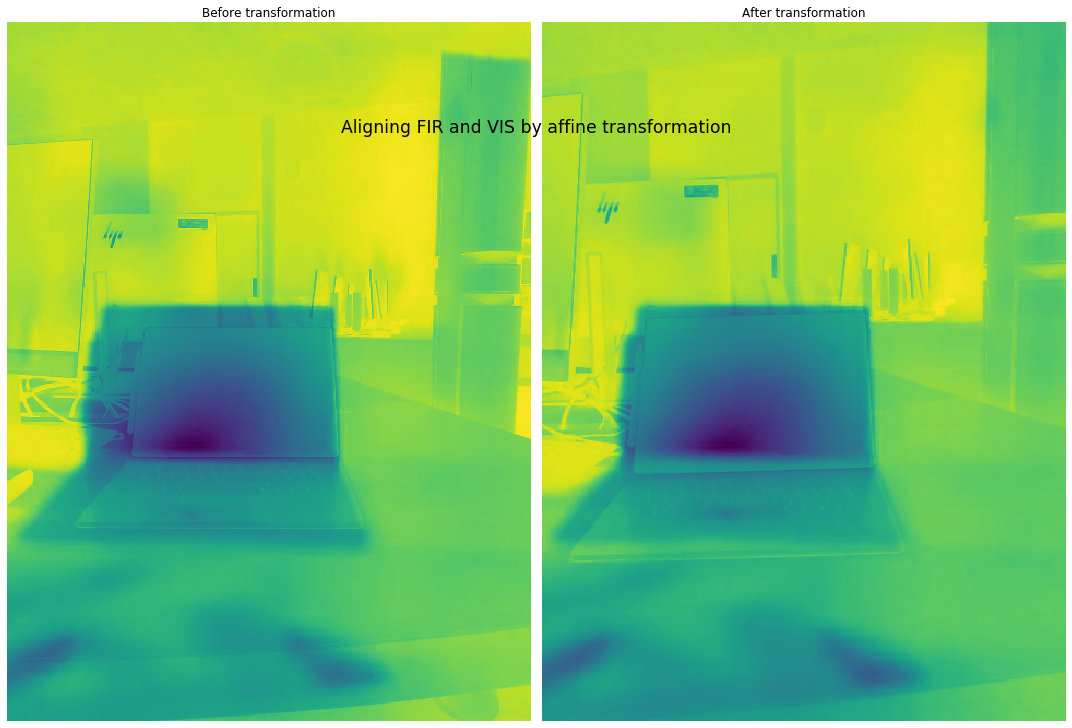

In [93]:
name = "flir_20191101T113900.jpg"
align(new_path, name, model.coef_, model.intercept_[::], portrait=True)

Scaling seems fine, but the rotation factor appears to be off. This is probably due to the sensor being less wobbly in portrait mode. For the generation of a dataset, it would be beneficial to collect some more test data and re-calibrate the transformation, depending on the orientation of the sensor.